## Supplement 4: Classification

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

### 4.3 Programming Task: Song popularity prediction using Logistic regression
The datasets __train-songs.csv__ and __test-songs.csv__ contain audio properties of various tracks
collected from the music streaming site Spotify.


The goal of the task is to train a logistic regression classifier that predicts if a given track is popular or not.

The dataset consists of 9 columns. The first 8 columns contain various audio properties which are provided as input features to the model. The last column contains the class labels given by 0 (not popular) and 1 (popular).

i\. Implement the loss function and its gradient for the logistic regression model.


In [2]:
# Define logistic function, logistic loss function, and gradient of logistic loss function
def sigmoid(arg):
   return 1 / (1 + np.exp(-1 * arg))

def logistic_regression_loss(x, y, w):
    loss = 0
    for i in range(len(x)):
        current_features = np.reshape(x[i], (-1,1))
        arg = np.squeeze(np.dot(w.T, current_features))
        h = sigmoid(arg)
        # Avoid logarithm of zero
        if h < 1e-50:
            h = 1e-50
        # Calculate loss
        loss += (-1 * y[i] * np.log(h)) - ((1 - y[i]) * np.log(1 - h))

    return 1 / len(x) * loss

def logistic_regression_gradient(x, y, w):
    gradient = 0
    for i in range(len(x)):
        current_features = np.reshape(x[i], (-1,1))
        arg = np.squeeze(np.dot(w.T, current_features))
        h = sigmoid(arg)
        # Calculate gradient
        gradient += (h - y[i]) * current_features

    return gradient

   ii\. Using the gradient descent algorithm, train the logistic regression model.
You may reuse/modify the gradient descent algorithm from the previous supplement.




In [3]:
# Rescale input features to range between -1 and +1
def rescale(features):
    rescaled_features = features
    for feature in range(features.shape[1]):
        maximum = np.amax(np.abs(features[:,feature]))
        for i in range(features.shape[0]):
            rescaled_features[i,feature] = features[i,feature] / maximum

    return rescaled_features

In [4]:
# Print training progress
def printProgressBar(iteration, total, decimals=1, length=100, fill='█', printEnd="\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration / float(total))
    bar = fill * filledLength + '-' * (length - filledLength)

    # Print current progress
    print(f'\r|{bar}| {percent}%', end=printEnd)

    # Print new line on complete
    if iteration == total:
        print()

In [5]:
# Implement Gradient Descent Algorithm
def GradientDescent(features, labels, weights, loss_function, gradient_loss_function,
                    eta=0.001, maxIter=1000, tolerance=1e-3):

    iteration = 0
    weight_values = [weights]
    loss_values = [loss_function(features, labels, weights)]

    # Start training process
    print('Training Progress:')
    printProgressBar(iteration, total=maxIter)

    for iteration in range(maxIter):
        printProgressBar(iteration+1, total=maxIter)

        gradient = gradient_loss_function(features, labels, weights)
        weights = weights - eta * gradient

        weight_values.append(weights)
        current_loss = loss_function(features, labels, weights)
        loss_values.append(current_loss)

        if np.linalg.norm(gradient) < tolerance:
            break

    # End of training process
    if iteration+1 < maxIter:
        printProgressBar(maxIter, total=maxIter)

    return np.array(weight_values), np.array(loss_values), int(iteration+1)

Training Progress:
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%


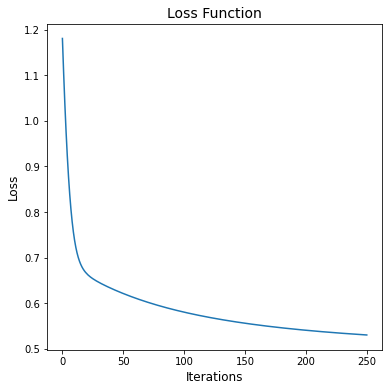

In [6]:
# Load training set data
train_songs = np.genfromtxt('train-songs.csv', dtype=float, delimiter=',', skip_header=1, usemask=False)

# Create arrays containing training labels and training features
train_labels = np.copy(train_songs)[:,-1]
train_features = rescale(np.copy(train_songs))
train_features[:,-1] = 1 # Add bias to training features

# Define parameters for gradient descent
initial_weights = np.random.rand(9, 1)
learning_rate = 1e-5
maxIterations = 250

# Apply gradient descent
weights_hist, loss_hist, iterations = GradientDescent(train_features, train_labels, initial_weights,
                                                      logistic_regression_loss, logistic_regression_gradient,
                                                      learning_rate, maxIterations)

# Plot loss curve
plt.figure(figsize=(6, 6))
plt.plot(np.arange(0, len(loss_hist)), loss_hist)
plt.title('Loss Function', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()

iii\. Using model predictions on __test-songs.csv__, build the confusion matrix and
subsequently calculate the __precision__, __recall__, and __F1-score__ for a threshold of 0.4.


In [7]:
def calculate_performance(weights_trained, features_test, labels_test, level=0.5):
    tp, fp, tn, fn = 0, 0, 0, 0

    for i in range(len(test_songs)):
        current_features = np.reshape(features_test[i], (-1,1))
        arg = np.squeeze(np.dot(weights_trained.T, current_features))
        sigmoid_output = sigmoid(arg)

        # Find ground truth and prediction values
        y, y_head = labels_test[i], 0
        if sigmoid_output > level:
            y_head = 1

        # Calculate values for confusion matrix
        if (y_head == y) and (y == 1): tp += 1
        elif (y_head == y) and (y == 0): tn += 1
        elif y == 1: fn += 1
        else: fp += 1

    return tp, fp, tn, fn

In [8]:
# Load test set data
test_songs = np.genfromtxt('test-songs.csv', dtype=float, delimiter=',', skip_header=1, usemask=False)

# Create arrays containing test labels and test features
test_labels = np.copy(test_songs)[:,-1]
test_features = rescale(np.copy(test_songs))
test_features[:,-1] = 1 # Add bias to test features

trained_weights = weights_hist[-1]

threshold = 0.4

# Calculate performance measures based on the test set
true_positives, false_positives, true_negatives, false_negatives = calculate_performance(trained_weights,
                                                                                         test_features,
                                                                                         test_labels,
                                                                                         threshold)

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * precision * recall / (precision + recall)

print('Results for threshold %.1f:\n' %threshold)
print(tabulate([['Actual False', true_negatives, false_positives],
                ['Actual True', false_negatives, true_positives]],
                headers=['Confusion Matrix', 'Predicted False', 'Predicted True']), '\n')

print('PRECISION:', str(int(precision*1000)/10)+'%')
print('RECALL:', str(int(recall*1000)/10)+'%')
print('F1-SCORE:', str(int(f1_score*1000)/10)+'%')

Results for threshold 0.4:

Confusion Matrix      Predicted False    Predicted True
------------------  -----------------  ----------------
Actual False                      620               380
Actual True                       129               871 

PRECISION: 69.6%
RECALL: 87.1%
F1-SCORE: 77.3%


iv\. Plot the __ROC curve__ for the model and calculate the __AUC metric__ of your model.


In [9]:
# Calculate false positive rates (FPR) and true positive rates (TPR)
def roc_auc(weights_trained, features_test, labels_test, step_size=0.1):
    true_positive_rates = []
    false_positive_rates = []
    thresholds = np.arange(0, 1, step=step_size)
    for i in range(len(thresholds)):
        tp, fp, tn, fn = calculate_performance(weights_trained, features_test, labels_test, thresholds[i])
        true_positive_rates.append(tp / (tp + fn))
        false_positive_rates.append(fp / (fp + tn))

    # Calculate area under curve (AUC) for trained model
    area_under_curve = 0
    for i in range(len(thresholds)-1):
        area_under_curve += (false_positive_rates[i] - false_positive_rates[i + 1]) * true_positive_rates[i]

    return true_positive_rates, false_positive_rates, area_under_curve

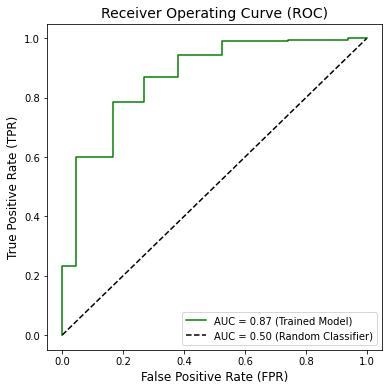

In [10]:
# Plot Receiver Operating Curve (ROC)
plt.figure(figsize=(6, 6))
tpr, fpr, auc = roc_auc(trained_weights, test_features, test_labels)
plt.step(fpr, tpr, 'g', where='post', label='AUC = %.2f (Trained Model)' %auc)
plt.plot([0, 1], [0, 1], "k--", label="AUC = 0.50 (Random Classifier)")
plt.title('Receiver Operating Curve (ROC)', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right')
plt.show()

v\. Consider the __simpler models__ given below. The input $\mathbf{x}$ in these models takes only 4 input features from the given dataset.

- Model A $~~~~~~~~~~~$   $\mathbf{x}$ = $[$ danceability, key, valence, tempo $]^\top$
- Model B $~~~~~~~~~~~$  $\mathbf{x}$ = $[$ danceability, loudness, acousticness, instrumentalness $]^\top$
- Model C $~~~~~~~~~~~$ $\mathbf{x}$ = $[$ key, liveness, valence, tempo $]^\top$

Train these models using your logistic regression implementation and
determine the __best performing model using the AUC metric__.

Training Progress:
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%
Training Progress:
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%
Training Progress:
|████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0%


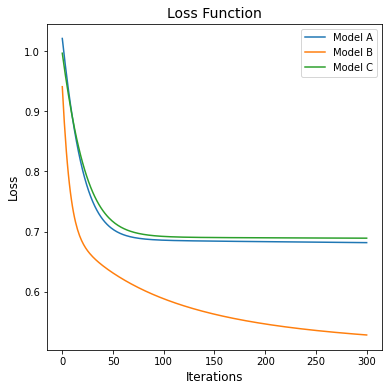

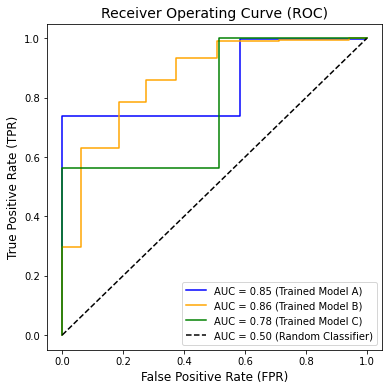

In [11]:
# Define parameters for Gradient Descent
initial_weights = np.random.rand(5, 1)
maxIterations = 300

learning_rate_a = 3e-6
learning_rate_b = 1e-5
learning_rate_c = 3e-6

# Train Model A
train_features_a = rescale(np.copy(train_songs[:,[0, 1, 6, 7, 8]]))
train_features_a[:,-1] = 1 # Add bias to training features of model A
test_features_a = rescale(np.copy(test_songs[:,[0, 1, 6, 7, 8]]))
test_features_a[:,-1] = 1 # Add bias to test features of model A
weights_hist_a, loss_hist_a, iterations_a = GradientDescent(train_features_a, train_labels, initial_weights,
                                                            logistic_regression_loss, logistic_regression_gradient,
                                                            learning_rate_a, maxIterations)
tpr_a, fpr_a, auc_a = roc_auc(weights_hist_a[-1], test_features_a, test_labels)

# Train Model B
train_features_b = rescale(np.copy(train_songs[:,[0, 2, 3, 4, 8]]))
train_features_b[:,-1] = 1 # Add bias to training features of model B
test_features_b = rescale(np.copy(test_songs[:,[0, 2, 3, 4, 8]]))
test_features_b[:,-1] = 1 # Add bias to test features of model B
weights_hist_b, loss_hist_b, iterations_b = GradientDescent(train_features_b, train_labels, initial_weights,
                                                            logistic_regression_loss, logistic_regression_gradient,
                                                            learning_rate_b, maxIterations)
tpr_b, fpr_b, auc_b = roc_auc(weights_hist_b[-1], test_features_b, test_labels)

# Train Model C
train_features_c = rescale(np.copy(train_songs[:,[1, 5, 6, 7, 8]]))
train_features_c[:,-1] = 1 # Add bias to training features of model C
test_features_c = rescale(np.copy(test_songs[:,[1, 5, 6, 7, 8]]))
test_features_c[:,-1] = 1 # Add bias to test features of model C
weights_hist_c, loss_hist_c, iterations_c = GradientDescent(train_features_c, train_labels, initial_weights,
                                                            logistic_regression_loss, logistic_regression_gradient,
                                                            learning_rate_c, maxIterations)
tpr_c, fpr_c, auc_c = roc_auc(weights_hist_c[-1], test_features_c, test_labels)

# Plot loss curve
plt.figure(figsize=(6, 6))
plt.plot(np.arange(0, len(loss_hist_a)), loss_hist_a, label='Model A')
plt.plot(np.arange(0, len(loss_hist_b)), loss_hist_b, label='Model B')
plt.plot(np.arange(0, len(loss_hist_c)), loss_hist_c, label='Model C')
plt.title('Loss Function', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')

# Plot Receiver Operating Curve (ROC)
plt.figure(figsize=(6, 6))
plt.step(fpr_a, tpr_a, 'blue', where='post', label='AUC = %.2f (Trained Model A)' %auc_a)
plt.step(fpr_b, tpr_b, 'orange', where='post', label='AUC = %.2f (Trained Model B)' %auc_b)
plt.step(fpr_c, tpr_c, 'green', where='post', label='AUC = %.2f (Trained Model C)' %auc_c)
plt.plot([0, 1], [0, 1], "k--", label="AUC = 0.50 (Random Classifier)")
plt.title('Receiver Operating Curve (ROC)', fontsize=14)
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.legend(loc='lower right')
plt.show()

Overall, all three models have lower accuracy regarding AUC than compared to the previous model with 8 training features:

0.87 > AUC(__Model B__)=0.86 > AUC(__Model A__)=0.85 > AUC(__Model C__)=0.78

Since the popularity of a song depends on multiple factors (i.e., danceability, key, loudness, etc.) the prediction accuracy generally correlates with the features selected for training and testing leading to different results for different models.

In this case, however, it is difficult to determine which model performs best as their AUC values are quite equal. The difference between model C and the remaining two models could be based on the fact that denceability is probably one of the most important factors for the popularity of a song.